In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# 1. Setup

In [2]:
import albumentations as A
import mermaidseg.datasets.dataset
import numpy as np
from mermaidseg.io import setup_config, get_parser, update_config_with_args
import copy
import torch
from matplotlib import pyplot as plt
import seaborn as sns 

from torch.utils.data import DataLoader, random_split
from mermaidseg.model.meta import MetaModel
from mermaidseg.model.eval import EvaluatorSemanticSegmentation
from mermaidseg.logger import Logger
from mermaidseg.model.train import train_model

2025-12-18 16:47:52.509036: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 16:47:52.522943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766076472.541545  149791 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766076472.547331  149791 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-18 16:47:52.565566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True

CUDA Device 0: Tesla T4


## Config

In [46]:
# Start off with a configuration file
cfg1 = setup_config(config_path='../configs/linear-dinov3-base.yaml', config_base_path='../configs/concept_mermaid.yaml')
cfg2 = setup_config(config_path='../configs/linear-dinov3-concept.yaml', config_base_path='../configs/concept_mermaid.yaml')
cfg3 = setup_config(config_path='../configs/linear-dinov3-concept-bottleneck.yaml', config_base_path='../configs/concept_mermaid.yaml')

# 2. Data

In [47]:
transforms = {}
for split in cfg3.augmentation:
    transforms[split] = A.Compose(
        [
            getattr(A, transform_name)(**transform_params) for transform_name, transform_params
                                                                 in cfg3.augmentation[split].items()
        ]
    )

In [48]:
dataset_name = cfg3.data.pop("name", None)
batch_size = cfg3.data.pop("batch_size", 4)
whitelist_sources = cfg3.data.pop("whitelist_sources", None)

In [49]:
cfg3.data.padding = 5

In [50]:
dataset_dict = {}
dataset_dict["train"] = getattr(mermaidseg.datasets.dataset, dataset_name)(transform = transforms[split], **cfg3.data)

In [51]:
total_size = len(dataset_dict["train"])
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset_dict["train"], [train_size, val_size, test_size], generator=generator)
train_dataset = torch.utils.data.Subset(train_dataset, range(5000))
val_dataset = torch.utils.data.Subset(val_dataset, range(1000))
test_dataset = torch.utils.data.Subset(test_dataset, range(1000))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True, collate_fn = dataset_dict["train"].collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=True, collate_fn = dataset_dict["train"].collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, drop_last=True, collate_fn = dataset_dict["train"].collate_fn)

In [52]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 1250
Number of validation batches: 250
Number of test batches: 250


In [53]:
dataset_dict["train"].num_classes, dataset_dict["train"].num_concepts

(16, 20)

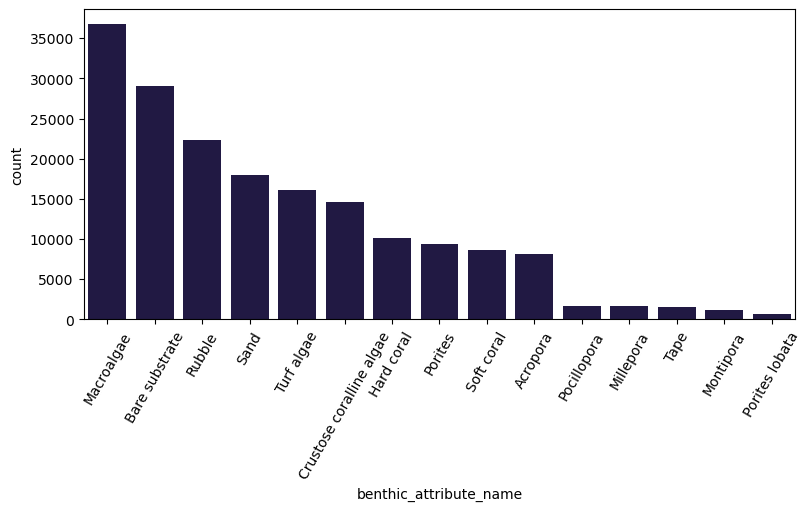

In [54]:
fig, ax = plt.subplots(figsize = (8, 5), layout = "compressed")
sns.barplot(dataset_dict["train"].df_annotations["benthic_attribute_name"].value_counts(), color = "#1C124A")
plt.xticks(rotation = 60)
plt.show()

In [55]:
dataset_dict["train"].benthic_concept_matrix

concept                  Acropora Acroporidae Bare substrate  \
level                           2           1              0   
Macroalgae                      0           0              0   
Rubble                          0           0              0   
Sand                            0           0              0   
Porites                         0           0              0   
Crustose coralline algae        0           0              0   
Bare substrate                  0           0              1   
Hard coral                      0           0              0   
Turf algae                      0           0              0   
Millepora                       0           0              0   
Tape                            0           0              0   
Soft coral                      0           0              0   
Acropora                        1           1              0   
Pocillopora                     0           0              0   
Porites lobata                  0           0              0   
Montipora                       0           1              0   

concept                  Crustose coralline algae Hard coral Macroalgae  \
level                                           0          0          0   
Macroalgae                                      0          0          1   
Rubble                                          0          0          0   
Sand                                            0          0          0   
Porites                                         0          1          0   
Crustose coralline algae                        1          0          0   
Bare substrate                                  0          0          0   
Hard coral                                      0          1          0   
Turf algae                                      0          0          0   
Millepora                                       0          1          0   
Tape                                            0          0          0   
Soft coral                                      0          0          0   
Acropora                                        0          1          0   
Pocillopora                                     0          1          0   
Porites lobata                                  0          1          0   
Montipora                                       0          1          0   

concept                  Millepora Milleporidae Montipora Other Pocillopora  \
level                            2            1         2     0           2   
Macroalgae                       0            0         0     0           0   
Rubble                           0            0         0     0           0   
Sand                             0            0         0     0           0   
Porites                          0            0         0     0           0   
Crustose coralline algae         0            0         0     0           0   
Bare substrate                   0            0         0     0           0   
Hard coral                       0            0         0     0           0   
Turf algae                       0            0         0     0           0   
Millepora                        1            1         0     0           0   
Tape                             0            0         0     1           0   
Soft coral                       0            0         0     0           0   
Acropora                         0            0         0     0           0   
Pocillopora                      0            0         0     0           1   
Porites lobata                   0            0         0     0           0   
Montipora                        0            0         1     0           0   

concept                  Pocilloporidae Porites Porites lobata Poritidae  \
level                                 1       2              3         1   
Macroalgae                            0       0              0         0   
Rubble                                0       0              0 

In [56]:
concepts = list(dataset_dict["train"].benthic_concept_matrix.columns.get_level_values("concept"))
concept_counts = {c: 0 for c in concepts}
for benthic_attribute in dataset_dict["train"].df_annotations["benthic_attribute_name"].value_counts().index:
    concept_vector = dataset_dict["train"].benthic_concept_matrix.loc[benthic_attribute].values
    for idx in np.where(concept_vector == 1)[0]:
        concept_counts[concepts[idx]] += int(dataset_dict["train"].df_annotations["benthic_attribute_name"].value_counts()[benthic_attribute])

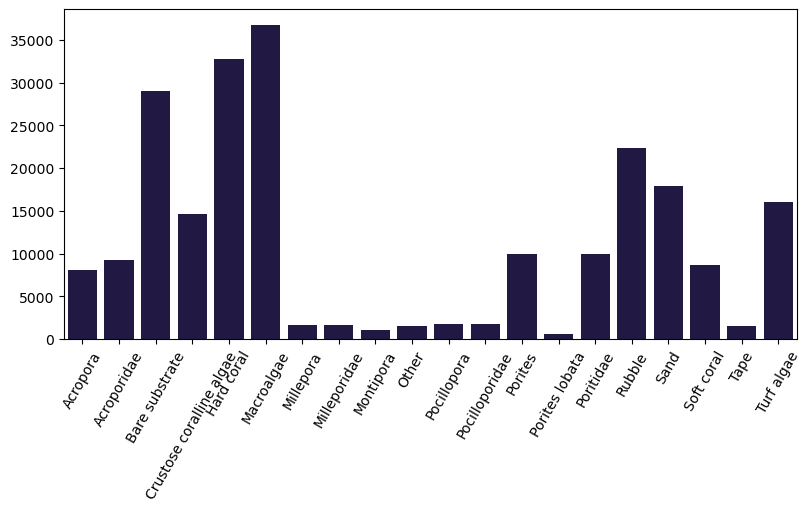

In [57]:
fig, ax = plt.subplots(figsize = (8, 5), layout = "compressed")
sns.barplot(concept_counts, color = "#1C124A")
plt.xticks(rotation = 60)
plt.show()

In [58]:
print("There are", len(dataset_dict["train"].df_annotations["benthic_attribute_name"]), "class annotations") 
print("There are", int(np.sum(list(concept_counts.values()))), "concept annotations")

There are 179803 class annotations
There are 227181 concept annotations


# 3. Model

In [59]:
meta_model1 = MetaModel(run_name = cfg1.run_name, 
                       num_classes = dataset_dict["train"].num_classes,
                       num_concepts = dataset_dict["train"].num_concepts,
                       device = device,
                       model_kwargs = cfg1.model,
                       training_mode = cfg1.training_mode,
                       training_kwargs = cfg1.training,
                       concept_matrix = dataset_dict["train"].benthic_concept_matrix,
                       conceptid2labelid = dataset_dict["train"].conceptid2labelid)

model_checkpoint = "./model_checkpoints/mermaid_base_run_dinov3/model_2025121414" 
checkpoint = torch.load(model_checkpoint, weights_only=False)
meta_model1.model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [60]:
meta_model2 = MetaModel(run_name = cfg2.run_name, 
                       num_classes = dataset_dict["train"].num_classes,
                       num_concepts = dataset_dict["train"].num_concepts,
                       device = device,
                       model_kwargs = cfg2.model,
                       training_mode = cfg2.training_mode,
                       training_kwargs = cfg2.training,
                       concept_matrix = dataset_dict["train"].benthic_concept_matrix,
                       conceptid2labelid = dataset_dict["train"].conceptid2labelid)

model_checkpoint = "./model_checkpoints/dinov3-test-concept-run/model_2025121714" 
checkpoint = torch.load(model_checkpoint, weights_only=False)
meta_model2.model.load_state_dict(checkpoint["model_state_dict"])

meta_model3 = MetaModel(run_name = cfg3.run_name, 
                       num_classes = dataset_dict["train"].num_classes,
                       num_concepts = dataset_dict["train"].num_concepts,
                       device = device,
                       model_kwargs = cfg3.model,
                       training_mode = cfg3.training_mode,
                       training_kwargs = cfg3.training,
                       concept_matrix = dataset_dict["train"].benthic_concept_matrix,
                       conceptid2labelid = dataset_dict["train"].conceptid2labelid)

model_checkpoint = "./model_checkpoints/dinov3-test-concept-bottleneck-run_2/model_2025121808" 
checkpoint = torch.load(model_checkpoint, weights_only=False)
meta_model3.model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

# 4. Evaluation

## 4.1 Quantitative Analysis

In [61]:
from torchmetrics.classification import Accuracy, F1Score, JaccardIndex

metric_dict = {
            "accuracy": Accuracy(task="multiclass", num_classes=int(dataset_dict["train"].num_classes), ignore_index = 0).to(device),
            "f1_macro": F1Score(task="multiclass", average = "macro", num_classes=int(dataset_dict["train"].num_classes), ignore_index = 0).to(device),
            "f1_class": F1Score(task="multiclass", average = "none", num_classes=int(dataset_dict["train"].num_classes), ignore_index = 0).to(device),
            }

concept_metric_dict = {
            "accuracy_concept": Accuracy(task="multiclass", average = "none", num_classes=3, ignore_index = 0).to(device),
            "f1_concept": F1Score(task="multiclass", average = "none", num_classes=3, ignore_index = 0).to(device),
            "iou_concept": JaccardIndex(task="multiclass", num_classes=3, ignore_index = 0, average='none').to(device)
            }
evaluator_final = EvaluatorSemanticSegmentation(num_classes=dataset_dict["train"].num_classes,
                                            device=device,
                                            metric_dict = metric_dict,
                                            calculate_concept_metrics=True,
                                            concept_metric_dict = concept_metric_dict
                                            )

In [ ]:
final_test_results1 = evaluator_final.evaluate_model(dataloader = test_loader, meta_model=meta_model1)
final_test_results2 = evaluator_final.evaluate_model(dataloader = test_loader, meta_model=meta_model2)
final_test_results3 = evaluator_final.evaluate_model(dataloader = test_loader, meta_model=meta_model3)

{'accuracy': MulticlassAccuracy(), 'f1_macro': MulticlassF1Score(), 'f1_class': MulticlassF1Score()}
{'accuracy_concept': MulticlassAccuracy(), 'f1_concept': MulticlassF1Score(), 'iou_concept': MulticlassJaccardIndex()}
concept-bottleneck


100%|██████████| 250/250 [06:32<00:00,  1.57s/it]


In [83]:
model_checkpoint = "./model_checkpoints/dinov3-test-concept-run/model_epoch2" 
checkpoint = torch.load(model_checkpoint, weights_only=False)
meta_model2.model.load_state_dict(checkpoint["model_state_dict"])
final_test_results_tmp = evaluator_final.evaluate_model(dataloader = test_loader, meta_model=meta_model2)

{'accuracy': MulticlassAccuracy(), 'f1_macro': MulticlassF1Score(), 'f1_class': MulticlassF1Score()}
{'accuracy_concept': MulticlassAccuracy(), 'f1_concept': MulticlassF1Score(), 'iou_concept': MulticlassJaccardIndex()}
concept


100%|██████████| 250/250 [07:00<00:00,  1.68s/it]
/opt/conda/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


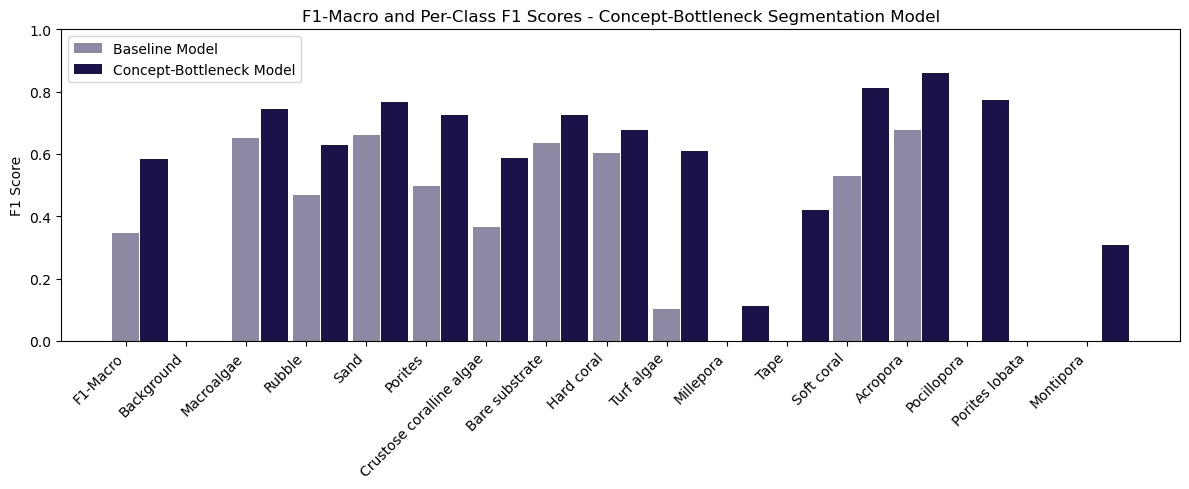

In [82]:
f1_values1 = [final_test_results1["f1_macro"]] + final_test_results1["f1_class"].tolist()
f1_values3 = [final_test_results3["f1_macro"]] + final_test_results3["f1_class"].tolist()
labels = ["F1-Macro", "Background", ] + list(dataset_dict["train"].label2id.keys())

plt.figure(figsize=(12,5))
plt.bar(np.arange(len(f1_values1)), f1_values1, width=0.45, color="#1C124A", alpha=0.5, label = "Baseline Model")
plt.bar(np.arange(len(f1_values3))+0.47, f1_values3, width=0.45, color="#1C124A", label = "Concept-Bottleneck Model")
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.title("F1-Macro and Per-Class F1 Scores - Concept-Bottleneck Segmentation Model")
plt.tight_layout()
plt.legend()
plt.show()

## 4.2 Qualitative Analysis

In [85]:
batch = next(iter(test_loader))
inputs, labels = batch

target_dim = (inputs.size(-2), inputs.size(-1))

inputs = inputs.to(device).float()
labels = labels.long().to(device)

segmentation_outputs1 = meta_model1.model(inputs)
segmentation_outputs2 = meta_model2.model(inputs)
segmentation_outputs3 = meta_model3.model(inputs)

outputs1 = segmentation_outputs1.logits
concept_outputs2 = segmentation_outputs2.logits
concept_outputs2 = torch.sigmoid(concept_outputs2)
concept_outputs3 = segmentation_outputs3.hidden_states
concept_outputs3 = torch.sigmoid(concept_outputs3)
outputs3 = segmentation_outputs3.logits

In [86]:
label2color = {"Sand": [194, 178, 128], "Rubble": [161, 153, 128], "Macroalgae" : [125, 163, 125], 
 "Porites": [255, 111, 194], "Porites lobata": [85, 53, 116], "Crustose coralline algae": [236, 150, 21],
 "Bare substrate": [125, 125, 125], "Hard coral": [224, 118, 119], "Turf algae": [0, 231, 255], 
 "Millepora": [244, 150, 115], "Soft coral": [255, 255, 0], 
 "Acropora": [236, 128, 255], "Pocillopora": [255, 146, 150], "Montipora": [240, 80, 80], "Tape": [0, 255, 0]}

id2color = {k:label2color[v] for k,v in dataset_dict["train"].id2label.items()}
id2color[0] = [255, 255, 255] # background

In [89]:
label_colors = np.array([[id2color[pixel] for pixel in row] for row in labels[0].detach().cpu().numpy()]) 
pred1_colors = np.array([[id2color[pixel] for pixel in row] for row in outputs1.argmax(dim=1)[0].detach().cpu().numpy()]) 
pred3_colors = np.array([[id2color[pixel] for pixel in row] for row in outputs3.argmax(dim=1)[0].detach().cpu().numpy()]) 

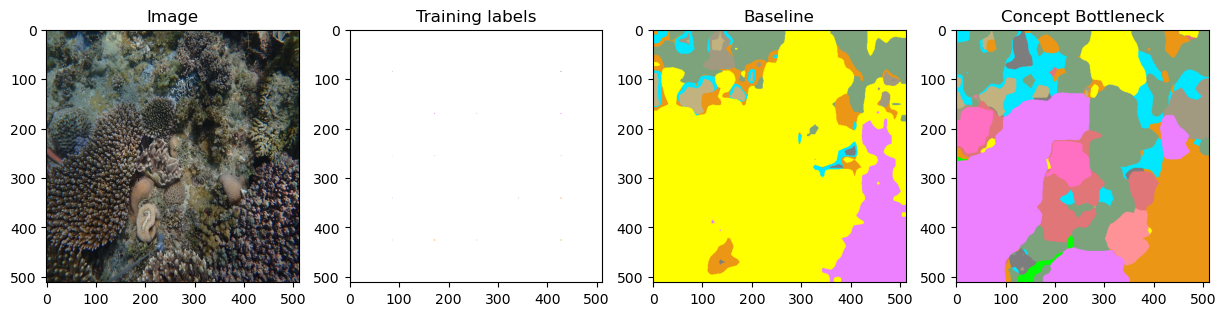

In [92]:
from mermaidseg.visualization import denormalize_image

fig, ax = plt.subplots(figsize = (15, 4), ncols = 4)
ax[0].imshow(denormalize_image(inputs[0].detach().cpu().numpy()).transpose(1,2,0))
ax[0].set_title("Image")
ax[1].imshow(label_colors)
ax[1].set_title("Training labels")
ax[2].imshow(pred1_colors)
ax[2].set_title("Baseline")
ax[3].imshow(pred3_colors)
ax[3].set_title("Concept Bottleneck")
plt.show()

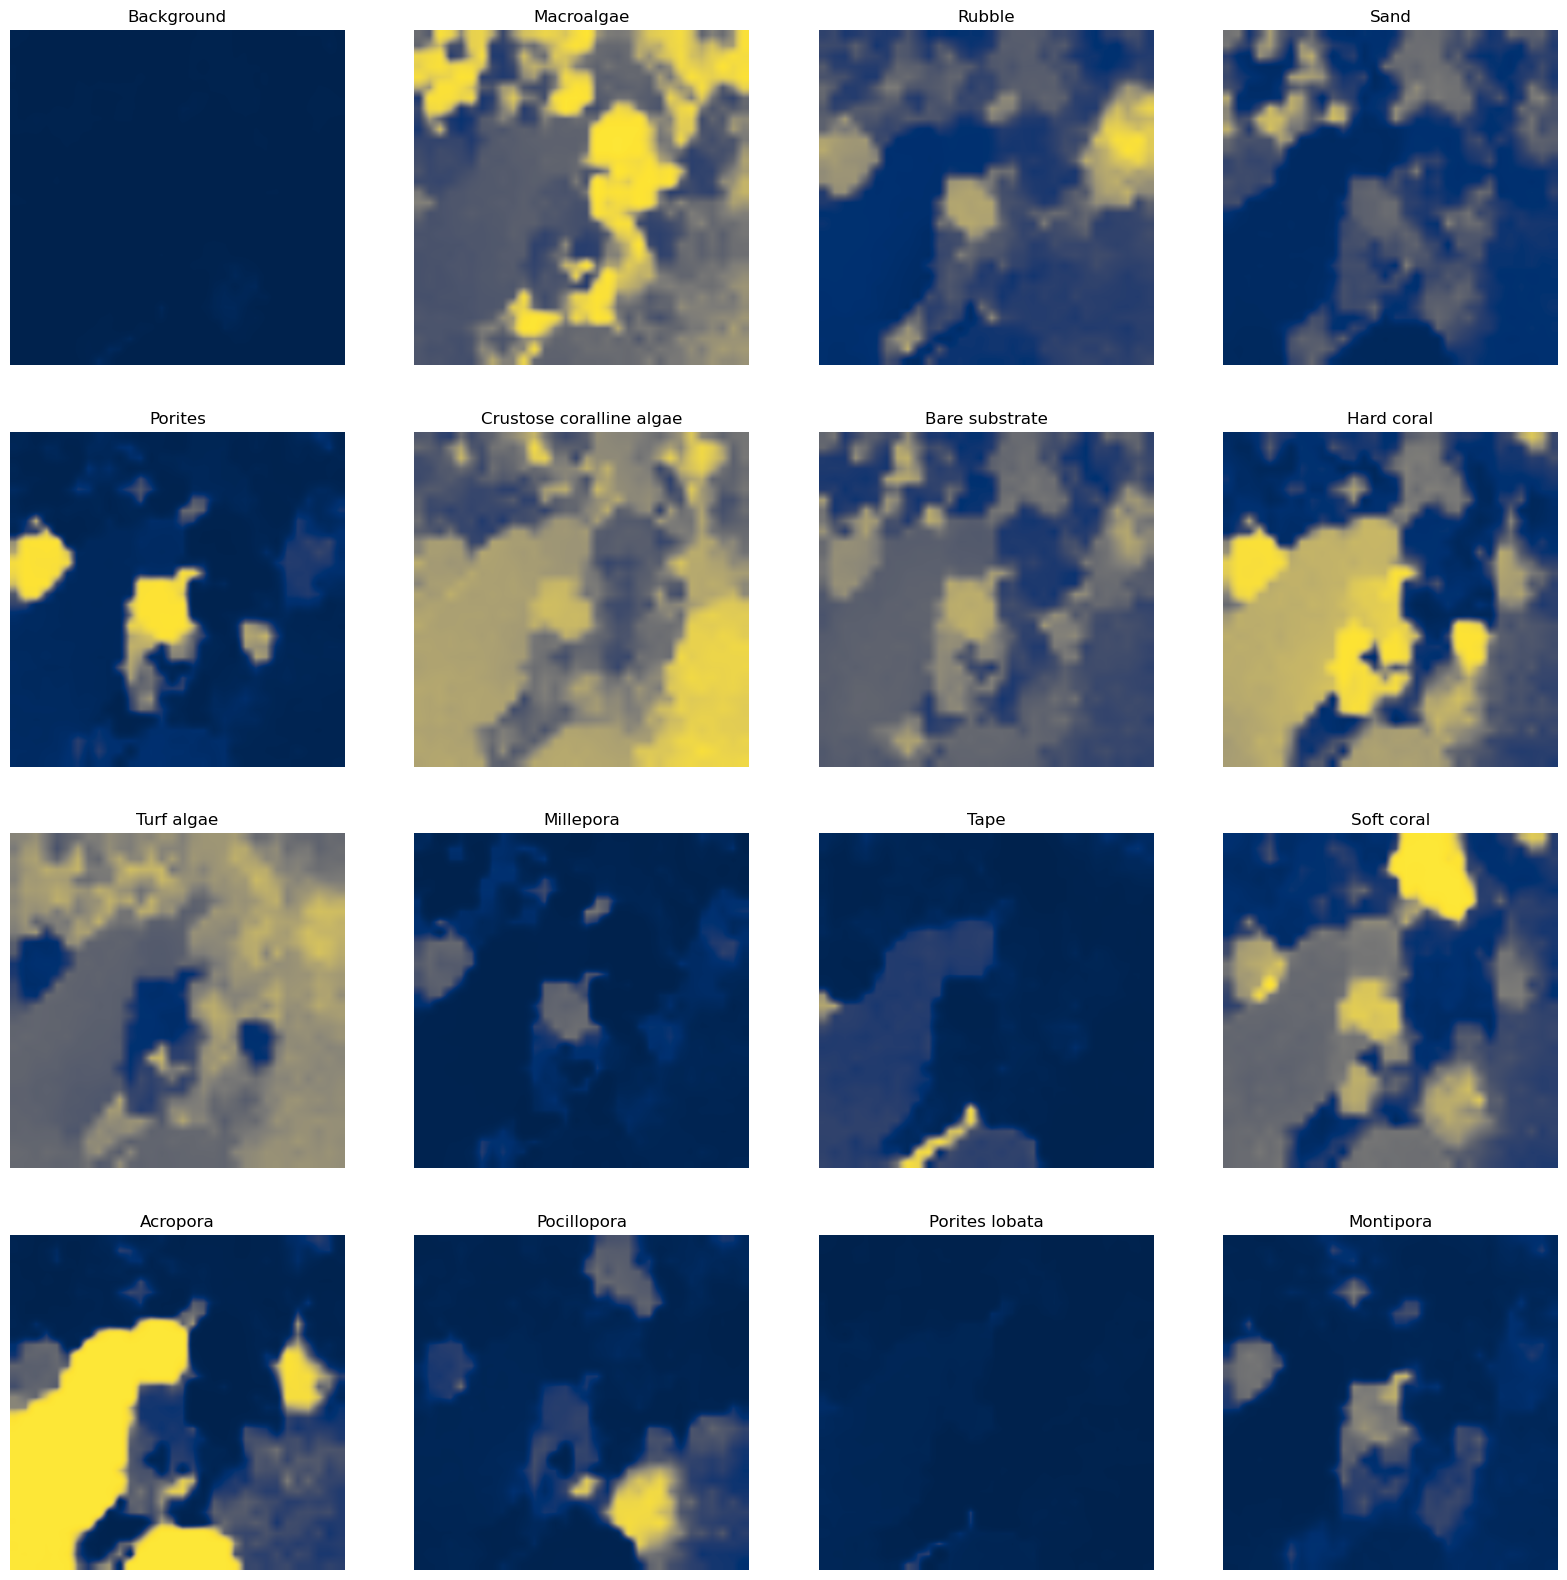

In [110]:
fig, ax = plt.subplots(figsize = (20, 20), ncols = 4, nrows = 4)
ax = ax.flatten()
preds_proba = torch.sigmoid(outputs3)
for i in range(outputs3.shape[1]):
    ax[i].axis('off')
    if i==0:
        ax[i].set_title("Background")
    else:
        ax[i].set_title(dataset_dict["train"].id2label[i])
    ax[i].imshow(preds_proba[0, i].detach().cpu().numpy(), vmin=0, vmax=1, cmap='cividis')
plt.show()

In [127]:
import gc
import torch

# Clear CUDA memory and remove large GPU tensors from globals

# List of large tensor/outputs names to remove (won't remove models or dataloaders)
_names_to_delete = [
    "segmentation_outputs1", "segmentation_outputs2", "segmentation_outputs3",
    "outputs1", "outputs3", "concept_outputs2", "concept_outputs3",
    "preds_proba", "inputs", "labels", "batch",
    "label_colors", "pred1_colors", "pred3_colors",
    "fig", "ax"
]

for _n in _names_to_delete:
    if _n in globals():
        try:
            del globals()[_n]
        except Exception:
            pass

# Force Python garbage collection
gc.collect()

# Free CUDA memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    try:
        torch.cuda.reset_peak_memory_stats()
    except Exception:
        # older torch versions may not have reset_peak_memory_stats
        pass

# Report memory usage
if torch.cuda.is_available():
    print("CUDA memory allocated:", torch.cuda.memory_allocated())
    print("CUDA memory reserved:", torch.cuda.memory_reserved())
    # Optional detailed summary (can be long)
    print(torch.cuda.memory_summary())
else:
    print("CUDA not available.")

CUDA memory allocated: 4825621504
CUDA memory reserved: 5379194880
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 4            |        cudaMalloc retries: 8         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4602 MiB |   4602 MiB |   6462 GiB |   6458 GiB |
|       from large pool |   4594 MiB |   4594 MiB |   6389 GiB |   6385 GiB |
|       from small pool |      7 MiB |      7 MiB |     73 GiB |     73 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   4602 MiB |   4602 MiB |   6462 GiB |   6458 GiB

In [119]:
batch = next(iter(val_loader))
inputs, labels = batch

target_dim = (inputs.size(-2), inputs.size(-1))

inputs = inputs.to(device).float()
labels = labels.long().to(device)

segmentation_outputs1 = meta_model1.model(inputs)
segmentation_outputs2 = meta_model2.model(inputs)
segmentation_outputs3 = meta_model3.model(inputs)

outputs1 = segmentation_outputs1.logits
concept_outputs2 = segmentation_outputs2.logits
concept_outputs2 = torch.sigmoid(concept_outputs2)
concept_outputs3 = segmentation_outputs3.hidden_states
concept_outputs3 = torch.sigmoid(concept_outputs3)
outputs3 = segmentation_outputs3.logits

In [120]:
id2color = {k:label2color[v] for k,v in dataset_dict["train"].id2label.items()}
id2color[0] = [255, 255, 255] # background

In [ ]:
label_colors = np.array([[id2color[pixel] for pixel in row] for row in labels[0].detach().cpu().numpy()]) 
pred1_colors = np.array([[id2color[pixel] for pixel in row] for row in outputs1.argmax(dim=1)[0].detach().cpu().numpy()]) 
pred3_colors = np.array([[id2color[pixel] for pixel in row] for row in outputs3.argmax(dim=1)[0].detach().cpu().numpy()]) 

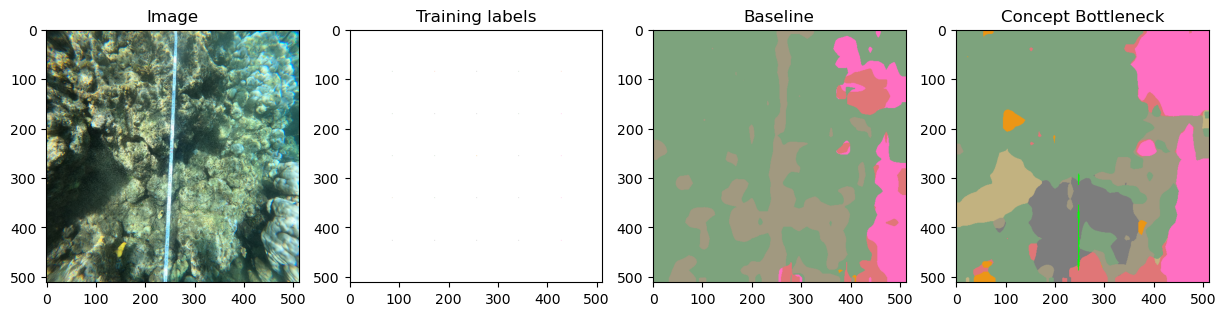

In [ ]:
from mermaidseg.visualization import denormalize_image

fig, ax = plt.subplots(figsize = (15, 4), ncols = 4)
ax[0].imshow(denormalize_image(inputs[0].detach().cpu().numpy()).transpose(1,2,0))
ax[0].set_title("Image")
ax[1].imshow(label_colors)
ax[1].set_title("Training labels")
ax[2].imshow(pred1_colors)
ax[2].set_title("Baseline")
ax[3].imshow(pred3_colors)
ax[3].set_title("Concept Bottleneck")
plt.show()

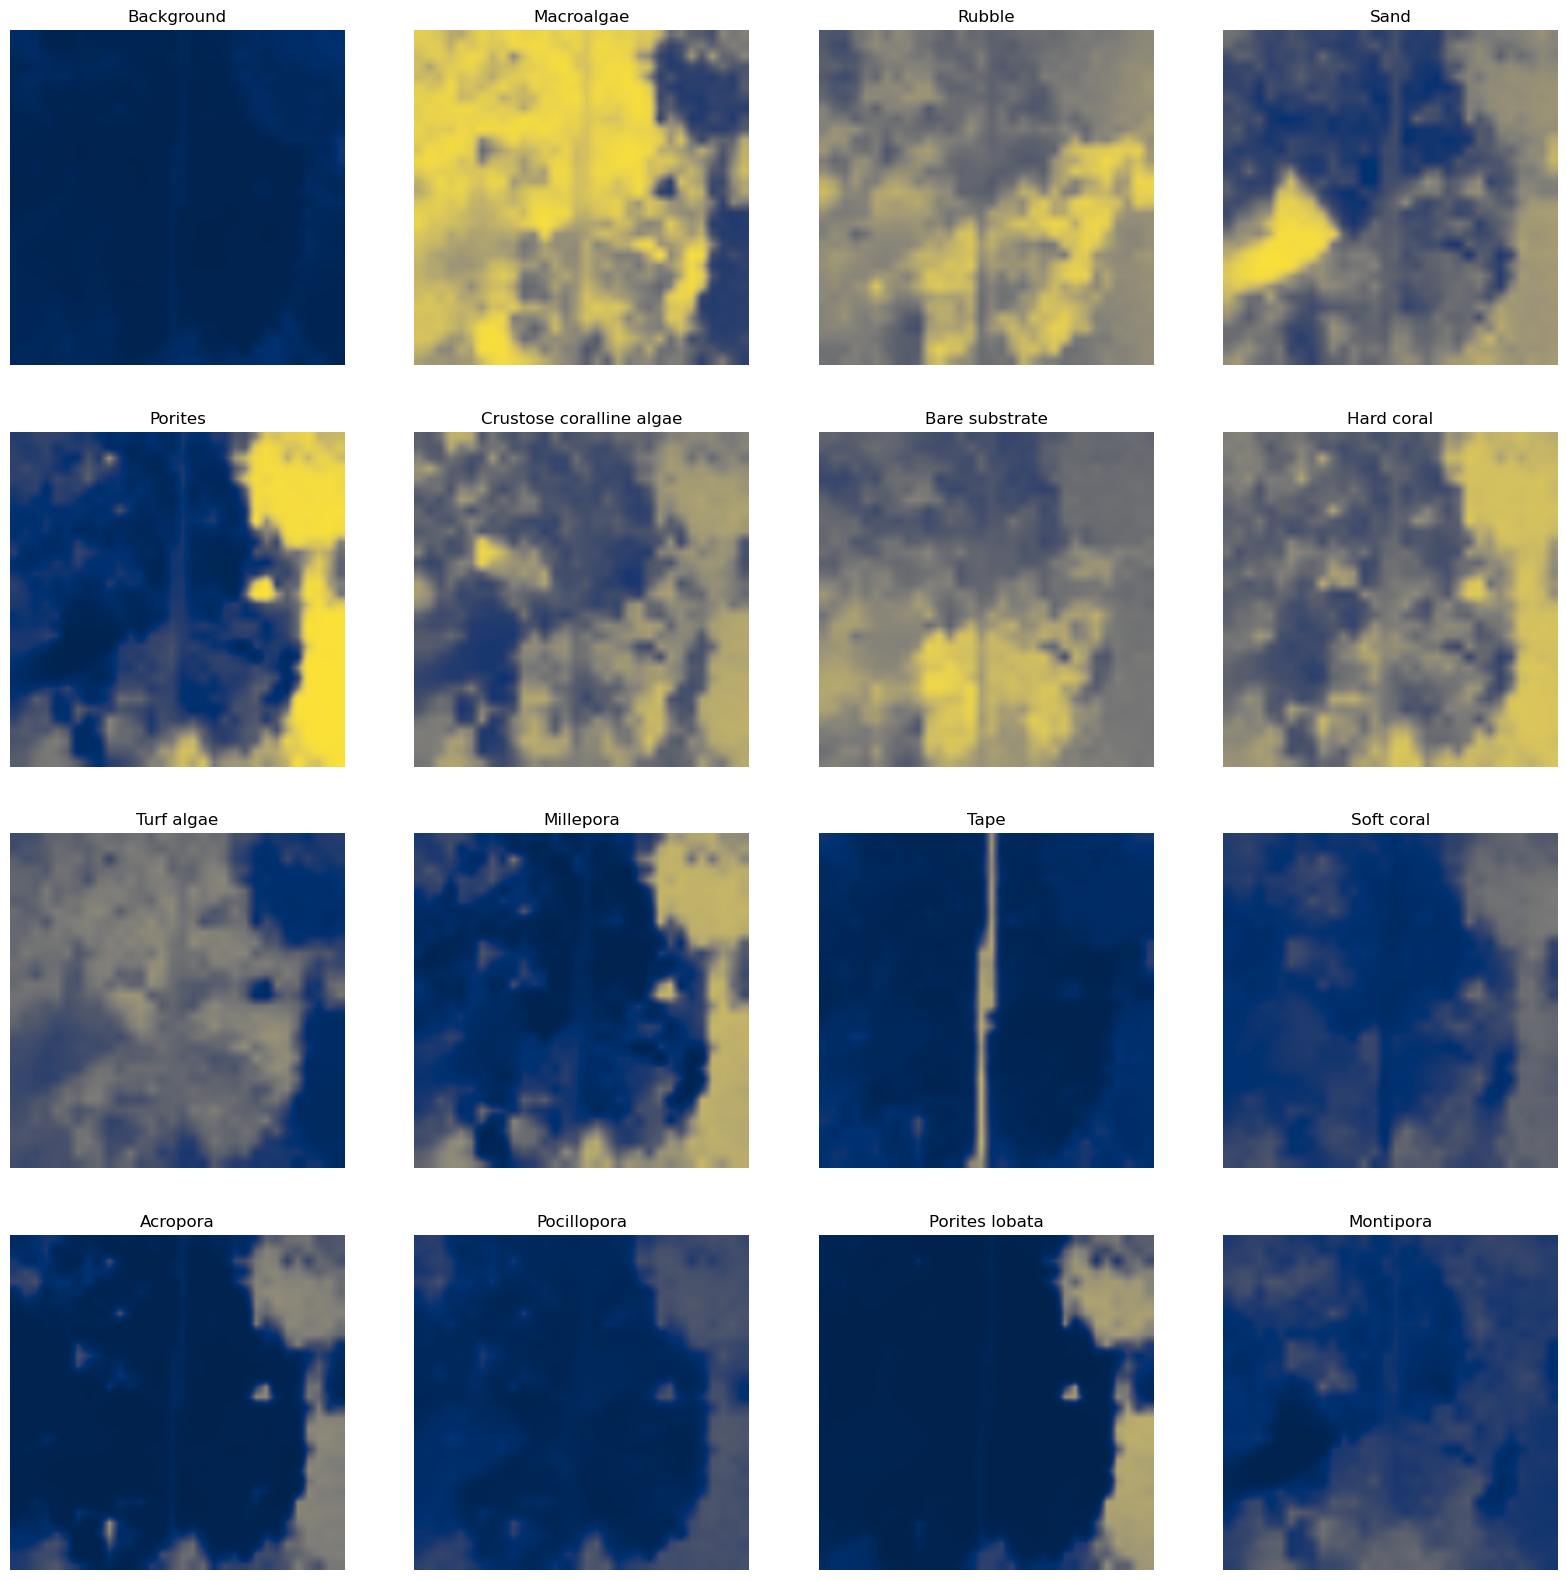

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20), ncols = 4, nrows = 4)
ax = ax.flatten()
preds_proba = torch.sigmoid(outputs3)
for i in range(outputs3.shape[1]):
    ax[i].axis('off')
    if i==0:
        ax[i].set_title("Background")
    else:
        ax[i].set_title(dataset_dict["train"].id2label[i])
    ax[i].imshow(preds_proba[0, i].detach().cpu().numpy(), vmin=0, vmax=1, cmap='cividis')
plt.show()

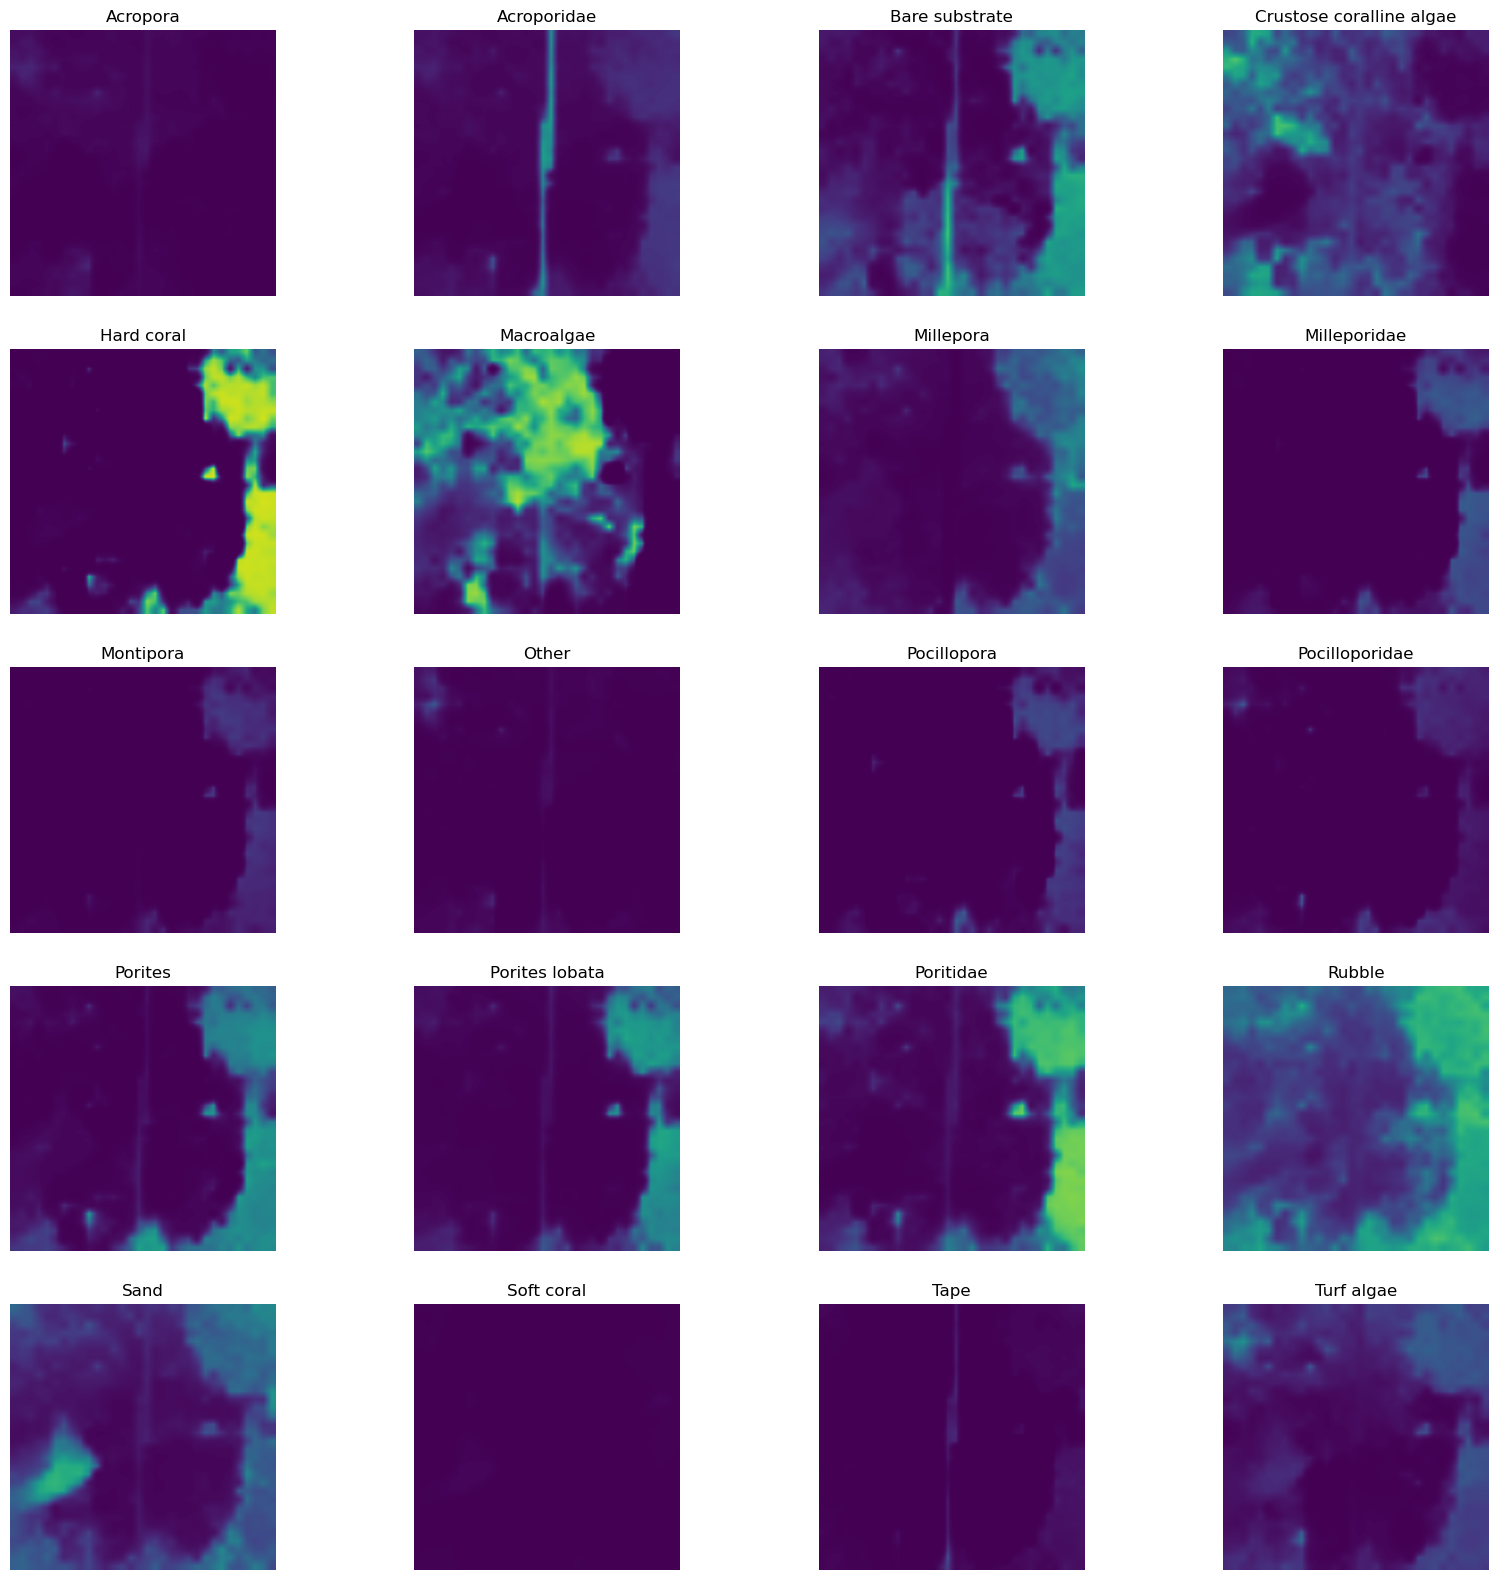

In [125]:
fig, ax = plt.subplots(figsize = (20, 20), ncols = 4, nrows = 5)
ax = ax.flatten()
for i in range(concept_outputs3.shape[1]):
    ax[i].axis('off')
    ax[i].set_title(dataset_dict["train"].id2concept[i+1])
    ax[i].imshow(concept_outputs3[0,i].detach().cpu().numpy(), vmin=0, vmax=1)
plt.show()

## 4.3 Confusion Matrix

In [138]:
import tqdm 
pred_list1 = []
label_list1 = []
for data in tqdm.tqdm(test_loader):
    inputs, labels = data
    labels = labels.long().to(device)
    outputs, concept_outputs = meta_model1.batch_predict(inputs)
    pred = outputs.argmax(dim=1)
    label_list1.extend(list(labels[labels>0].detach().cpu().numpy()))
    pred_list1.extend(list(pred[labels>0].detach().cpu().numpy()))

100%|██████████| 250/250 [06:49<00:00,  1.64s/it]


In [135]:
import tqdm 
pred_list = []
label_list = []
for data in tqdm.tqdm(test_loader):
    inputs, labels = data
    labels = labels.long().to(device)
    outputs, concept_outputs = meta_model3.batch_predict(inputs)
    pred = outputs.argmax(dim=1)
    label_list.extend(list(labels[labels>0].detach().cpu().numpy()))
    pred_list.extend(list(pred[labels>0].detach().cpu().numpy()))

  1%|          | 3/250 [00:04<06:50,  1.66s/it]

100%|██████████| 250/250 [07:01<00:00,  1.69s/it]


In [136]:
len(label_list), len(pred_list)

(77619, 77619)

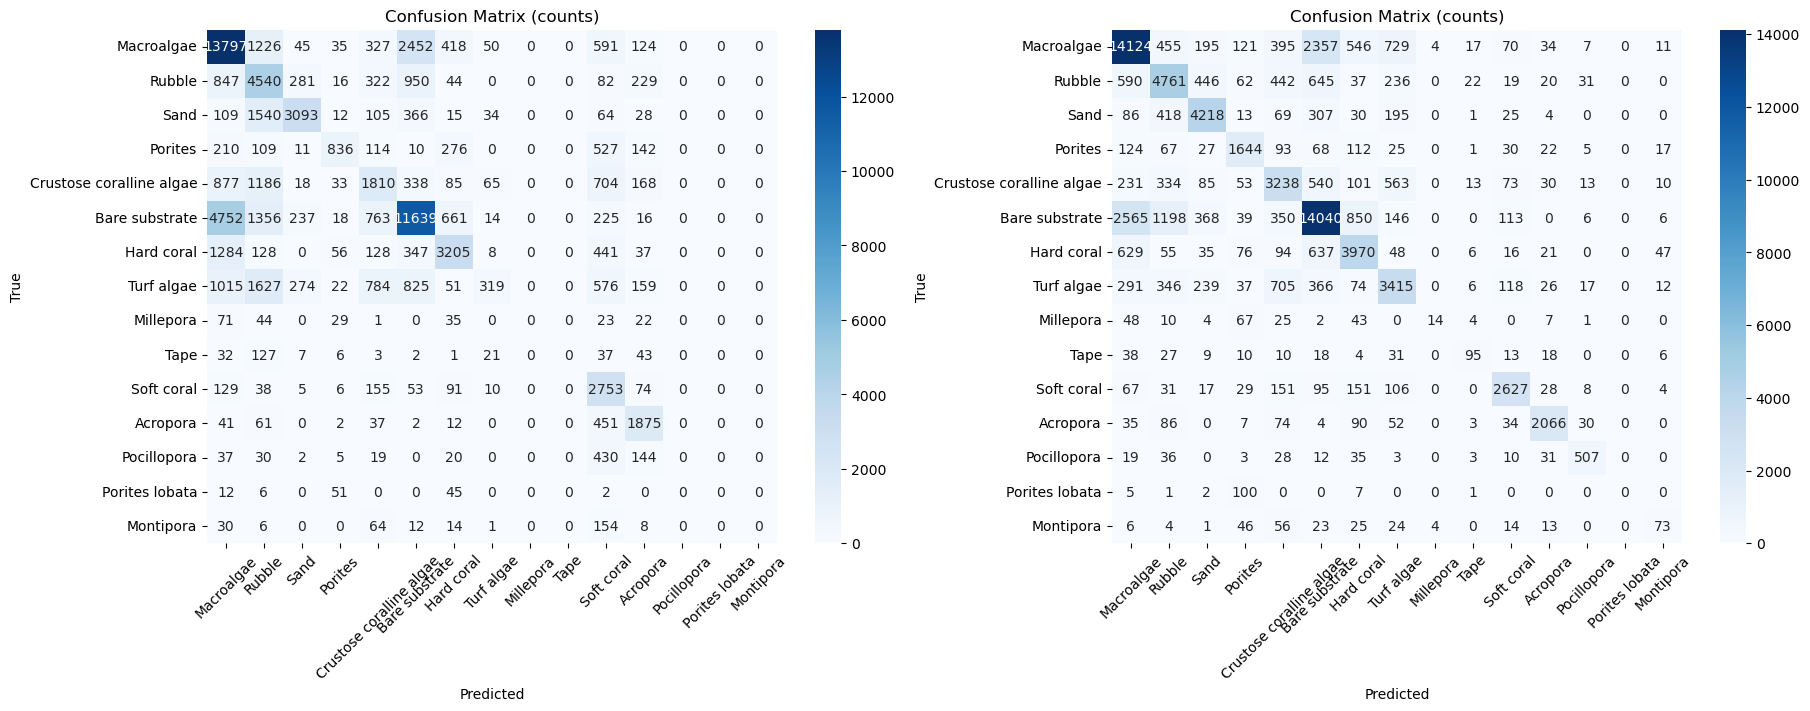

In [139]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# plot raw counts and normalized side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 7), constrained_layout=True)

# true / pred arrays
y_true = np.array(label_list1)
y_pred = np.array(pred_list1)

# determine classes present and human-readable names
classes = np.unique(np.concatenate([y_true, y_pred]))
class_names = [dataset_dict["train"].id2label[int(c)] for c in classes]

# confusion matrix (raw counts) and normalized (row-wise)
cm = confusion_matrix(y_true, y_pred, labels=classes)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, row_sums, where=(row_sums != 0))


sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names),
            ax=axes[0], cmap="Blues", annot=True, fmt="d", cbar=True)
axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].tick_params(axis='x', rotation=45)

# true / pred arrays
y_true = np.array(label_list)
y_pred = np.array(pred_list)

# determine classes present and human-readable names
classes = np.unique(np.concatenate([y_true, y_pred]))
class_names = [dataset_dict["train"].id2label[int(c)] for c in classes]

# confusion matrix (raw counts) and normalized (row-wise)
cm = confusion_matrix(y_true, y_pred, labels=classes)
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, row_sums, where=(row_sums != 0))


sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names),
            ax=axes[1], cmap="Blues", annot=True, fmt="d", cbar=True)
axes[1].set_title("Confusion Matrix (counts)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].tick_params(axis='x', rotation=45)

plt.show()

In [140]:
from mermaidseg.datasets.concepts import initialize_benthic_hierarchy
hierarchy_dict = initialize_benthic_hierarchy()

In [144]:
from mermaidseg.datasets.concepts import generate_hierarchy_path

In [155]:
dist_matrix = np.zeros((15,15))
for i in range(1,16):
    for j in range(1,16):
        path1 = generate_hierarchy_path(dataset_dict["train"].id2label[i], hierarchy_dict)
        path2 = generate_hierarchy_path(dataset_dict["train"].id2label[j], hierarchy_dict)
        dist_matrix[i-1,j-1] =  len(set(path1) | set(path2))

In [154]:
dist_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 2., 2., 4., 2., 2., 2., 2., 4., 3., 2., 4., 4., 5.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [ ]:
generate_hierarchy_path(dataset_dict["train"].id2label[4], hierarchy_dict)

['Porites', 'Poritidae', 'Hard coral']

In [152]:
generate_hierarchy_path(dataset_dict["train"].id2label[8], hierarchy_dict)

['Turf algae']

In [133]:
labels[labels>0]

tensor([ 1,  1,  1,  1,  1,  1, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12,  1,  5,  5, 12,  1,  5,  5, 12,  5,  5,  1,  5,  5, 12,
         5,  5,  1,  5,  5,  5,  5,  5,  2,  1,  1,  1,  5,  5,  5,  2,  1,  1,
         1,  5,  5,  5,  2,  1,  1,  1,  5,  5,  5,  2,  1,  1,  1,  5, 12, 12,
        12, 12,  5,  5, 12, 12, 12, 12,  5,  2,  2, 12, 12, 12, 12,  5,  2,  2,
         2, 12, 12, 12,  5,  2,  2,  2, 12, 12, 12,  5,  2,  2,  6,  6,  6,  6,
         3,  3,  3,  6,  6,  6,  6,  3,  3,  3,  6,  5,  5,  5,  6,  6,  6,  6,
         5,  5,  5,  6,  6,  6,  6,  8,  8,  6, 11, 11, 11,  6,  8,  8, 11, 11,
        11, 11,  6,  8,  8, 11, 11, 11, 11,  6,  8,  8,  6,  6,  6,  6,  6,  8,
         8,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,
         7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7, 